# How to use this notebook

1. Run the dependencies.
2. if needed, mount your good drive account.
3. Run the model architecture code.
4. Choose a dataset to use.
5. Run the loss function cells.
6. Train the model.

# Dependencies

Run the cell below, and wait for it to run completely. It's going to ask you to restart runtime. Restart the runtime and then run the cell again. Then the notebook should be good to go.

In [ ]:
import os
import glob
import time

import numpy as np
import pandas as pd
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils import data
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset, DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

!pip install --upgrade Pillow
from PIL import Image
from PIL import Image, ImageFilter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model architecture
ResNet-152

The input images are resized to (channels, x-dim, y-dim) = (3, 224, 224), which is reqiured by the ResNet-152 model.

In [ ]:
def conv2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = (np.floor((img_size[0] + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0] + 1).astype(int),
                np.floor((img_size[1] + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1] + 1).astype(int))
    return outshape

def convtrans2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = ((img_size[0] - 1) * stride[0] - 2 * padding[0] + kernel_size[0],
                (img_size[1] - 1) * stride[1] - 2 * padding[1] + kernel_size[1])
    return outshape


## ---------------------- ResNet VAE ---------------------- ##
class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )
        self.expand_channels = nn.Conv2d(1, 3, kernel_size=1)
        self.contract_channels = nn.Conv2d(3, 1, kernel_size=1)

    def encode(self, x):
        #print(x.shape)
        x = self.expand_channels(x)
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.relu(self.fc_bn4(self.fc4(z)))
        x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        x = self.contract_channels(x)
        #print(x.shape)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar

# Data

## 2-D microstructure data

In [ ]:
class Dataset(data.Dataset):
    "Characterizes a dataset for PyTorch"
    def __init__(self, filenames, labels, transform=None):
        "Initialization"
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.filenames)


    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        filename = self.filenames[index]
        X = Image.open(filename)

        if self.transform:
            X = self.transform(X)     # transform

        y = torch.LongTensor([self.labels[index]])
        return X, y

## ---------------------- end of Dataloaders ---------------------- ##

In [ ]:
DIR = "drive/MyDrive/2D_less_data/data/"
def multiplicate_data(dir_raw_data):
  dirs = os.listdir(DIR)
  labels = []
  images = []
  for idx in tqdm(range(len(dirs))):
    i = dirs[idx]
    direc = os.path.join(DIR, i)
    list_dir = os.listdir(direc)
    for img_f in list_dir:
      img_path = direc + '/' + img_f
      img_raw = mpimg.imread(img_path).astype(np.uint8)

      img = Image.fromarray(img_raw)
      #img_rotated_cw = img.rotate(15)
      #img_rotated_ccw = img.rotate(-15)
      img_upside_down = img.rotate(180)
      img_90_right = img.rotate(90)
      img_90_left = img.rotate(-90)
      img_flipped_h = img.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
      img_flipped_v = img.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
      img_blurred = img.filter(filter=ImageFilter.BLUR)
      transformations = [img,
                         #img_rotated_cw,
                         #img_rotated_ccw,
                         img_upside_down,
                          img_90_left, img_90_right, img_flipped_h,
                          img_flipped_v, img_blurred]
      for pic in transformations:
        # pic = center_crop(pic, 100) # input image dimension
        try:
          images.append(np.array(pic.getdata(), dtype='uint8').reshape(pic.size[0], pic.size[1], 3))
        except ValueError:
          arr = np.repeat(np.array(pic.getdata(), dtype='uint8').reshape(pic.size[0], pic.size[1])[:, :, np.newaxis], 3, axis=2)
          images.append(arr)
      labels.extend([int(i)]*len(transformations))

  return images, labels
images, labels = multiplicate_data(DIR)

In [ ]:
images = np.array(images)
labels = np.array(labels)

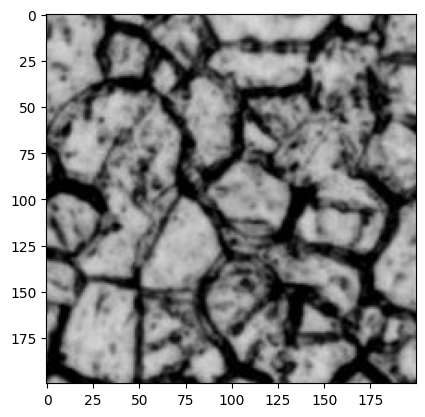

In [ ]:
img1 = images[(labels==7)][0]
plt.imshow(img1)

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomTensorDataset(Dataset):
  def __init__(self, data_X, data_y, transform_list=None):
    X_tensor, y_tensor = torch.tensor(data_X), torch.tensor(data_y)
    tensors = (X_tensor, y_tensor)
    assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
    self.tensors = tensors
    self.data = (data_X, data_y)
    self.transforms = transform_list

  def __getitem__(self, index):
    x = self.data[0][index]

    if self.transforms:
      x = self.transforms(x)

    y = self.tensors[1][index]

    return x, y

  def __len__(self):
    return self.tensors[0].size(0)

In [ ]:
res_size = 224        # ResNet image size
batch_size = 10
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])  # for grayscale images

# Load 2D microstructure data
dataset = CustomTensorDataset(images, labels, transform)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.7), int(len(dataset)) - int(len(dataset)*0.7)])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])  # for grayscale images

# -------------------- uncomment this for 2D microstructures ----------------------------
# # Load 2D microstructure data
# dataset = CustomTensorDataset(images, labels, transform)
# train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.7), int(len(dataset)) - int(len(dataset)*0.7)])
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


## Circles and Squares data

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        image = Image.open(os.path.join(self.img_dir, img_name))

        if self.transform:
            image = self.transform(image)

        # convert shape type to binary: 0 for Square, 1 for Circle
        shape_type = 0 if self.labels.iloc[idx, 1] == "Square" else 1

        # returning image, shape type and number of shapes as a tuple
        return image, shape_type


class ThresholdTransform(object):
    def __init__(self, thr_255):
        self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

    def __call__(self, x):
        return (x > self.thr).to(x.dtype)  # do not change the data type


res_size = 224
batch_size = 32

# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to the range [-1, 1]
    #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize([res_size, res_size]),
    ThresholdTransform(thr_255=240),
])

dataset = CustomDataset('drive/MyDrive/argonne/labels.csv', 'drive/MyDrive/argonne/shape_images', transform)
#dataset = torch.load("/content/gdrive/MyDrive/argonne/shape_images/dataset.pt")
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.7), int(len(dataset)) - int(len(dataset)*0.7)])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def show_tensor(t):
    plt.figure()
    plt.imshow(t.permute(1, 2, 0))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


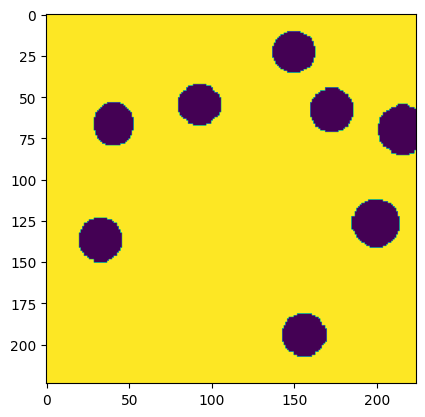

In [ ]:
img1 = train_dataset[2][0]
show_tensor(img1)

## MNIST data

In [ ]:
# Set the seed for reproducibility
torch.manual_seed(42)
res_size = 224
# Set the batch size for training and testing
batch_size = 64

# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to the range [-1, 1]
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize([res_size, res_size]),
])

# Set the path to store the MNIST dataset (change it to your desired path)
mnist_data_path = './mnist_data'

# Download and load the training dataset
train_dataset = datasets.MNIST(root=mnist_data_path, train=True, transform=transform, download=True)

# Download and load the test dataset
test_dataset = datasets.MNIST(root=mnist_data_path, train=False, transform=transform, download=True)

# Create dataloaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 242518717.19it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25236602.88it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 73149976.69it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5573589.46it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



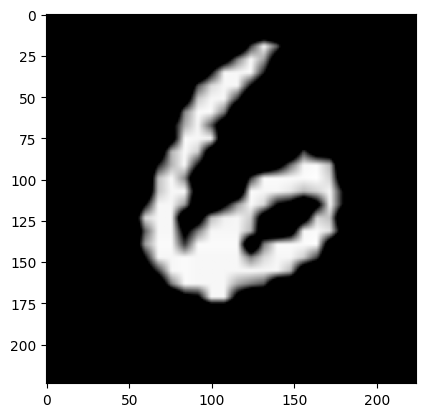

In [ ]:
img1 = train_dataset[299][0]
show_tensor(img1)

## Imagenet data

### TODO: fix imagenet corrupted data

In [ ]:
import random
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

config = {'lr':1e-3,
          'wd':1e-2,
          'bs':256,
          'img_size':128,
          'epochs':100,
          'seed':1000}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])
train_paths = np.random.choice(glob.glob('drive/MyDrive/imagenette/imagenette2-160/train/n03394916/*.JPEG'),10000)
valid_paths = np.random.choice(glob.glob('drive/MyDrive/imagenette/imagenette2-160/val/n03394916/*.JPEG'),1000)

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])  # for grayscale images

class ImageNetDataset(Dataset):
    def __init__(self,paths,augmentations=None, transforms=None):
        self.paths = paths
        self.augmentations = augmentations
        self.transforms=transforms

    def __getitem__(self,idx):
        path = self.paths[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']
        if self.transforms:
            image = self.transforms(image)

        return image

    def __len__(self):
        return len(self.paths)


class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #label = image_filepath.split('/')[-2]
        #label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image["image"])

        return image, #label

# test_dataset = ImageNetDataset(valid_paths,augmentations=get_train_transforms(), transforms=transform)
# test_dl = DataLoader(test_dataset,batch_size=16,shuffle=False,num_workers=4)

# dataiter = iter(test_dl)
# sample = next(dataiter)

test_dataset = LandmarkDataset(valid_paths, transform=transform)
test_dl = DataLoader(test_dataset,batch_size=16,shuffle=False,num_workers=4)

dataiter = iter(test_dl)
sample = next(dataiter)

img = torchvision.utils.make_grid(sample).permute(1,2,0).numpy()
plt.figure(figsize=(15,15))
plt.imshow(img)

def get_train_transforms():
    return A.Compose(
        [
            A.Resize(config['img_size'],config['img_size'],always_apply=True),
            A.Normalize(),
            ToTensorV2(p=1.0)
        ])
## train
train_dataset = ImageNetDataset(train_paths,augmentations=get_train_transforms(), transforms=transform)
train_loader = DataLoader(train_dataset,batch_size=config['bs'],shuffle=True,num_workers=4)

#valid
valid_dataset = ImageNetDataset(valid_paths,augmentations=transform)
valid_loader = DataLoader(valid_dataset,batch_size=config['bs'],shuffle=False,num_workers=4)

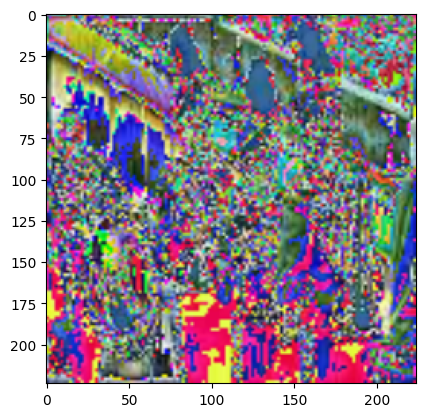

In [ ]:
img1 = train_dataset[0]
plt.imshow(img1.permute(1, 2, 0))

## Describable Texture Dataset (DTD)

In [ ]:
# h-params
batch_size = 128
res_size = 224

# Set up data transformations
transform = transforms.Compose([
    transforms.Resize((res_size, res_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image to [-1, 1]
])

# Set the path to store the MNIST dataset (change it to your desired path)
dtd_data_path = './dtd_data'

# Download and load the training dataset
train_dataset = datasets.DTD(root=dtd_data_path, split='train', transform=transform, download=True)
test_dataset = datasets.DTD(root=dtd_data_path, split='val', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def show_tensor(t):
    plt.figure()
    plt.imshow(t.permute(1, 2, 0))

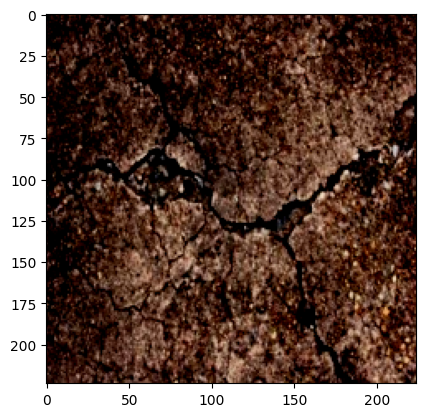

In [ ]:
img1 = train_dataset[299][0]
show_tensor(img1)

# Spatial Stats Code

## Calculate 2-pt Spatial Statistics: FFT Approach

NOT compatible with feeding batches of images. Scroll down for the function that takes in batches of images.

### Generate microstructure function

In [ ]:
el = res_size  # number of elements per side in the microstructure
H = 2  # number of phases in the microstructure
vf = .4  # volume fraction of phase 0
iA = 0  # phase A of correlation
iB = 0  # phase B of correlation

def generate_torch_microstructure_function(micr, H, el):
    """
    Inputs:
    micr: microstructure image (torch.Tensor) of shape W x H
    H: number of phases in the microstructure (int)
    el: length of micr along one dimension in pixels (int)

    returns:
    torch.Tensor microstructure function
    """
    mf = torch.zeros((H, el, el), device=micr.device, requires_grad=True)
    with torch.no_grad():
        for h in range(H):
            mf[h, ...] = micr.eq(h).clone().detach().to(micr.device)
    #frac = torch.sum(mf[0, ...]).float() / mf[0, ...].numel()
    #print("volume fraction phase 0: %s" % round(frac.item(), 2))
    return mf

def calculate_2point_torch_spatialstat(mf, H, el):
    """
    Inputs:
    mf: microstructure function torch.Tensor
    H: number of phases in the microstructure (int)
    el: length of micr along one dimension in pixels (int)

    returns:
    ff_v2: 2d torch.Tensor FFT function
    """
    st = time.time()

    M = torch.zeros((H, el, el), dtype=torch.complex128, device=mf.device)

    for h in range(H):
        M[h, ...] = torch.fft.fftn(mf[h, ...], dim=[0, 1])

    S = el**2

    M1 = M[iA, ...]
    mag1 = torch.abs(M1)

    eps=1e-6
    ang1 = torch.arctan2(M1.imag, M1.real+eps)
    exp1 = torch.exp(-1j*ang1)
    term1 = mag1*exp1

    M2 = M[iB, ...]
    mag2 = torch.abs(M2)
    ang2 = torch.arctan2(M2.imag, M2.real+eps)
    exp2 = torch.exp(1j*ang2)
    term2 = mag2*exp2

    FFtmp = term1*term2/S

    ff_v2 = torch.fft.ifftn(FFtmp, [el, el], [0, 1]).real

    timeT = round(time.time()-st, 5)
    print("correlation computed: %s s" % timeT)
    return ff_v2

def two_point_autocorr_pytorch(imgs, H=2):
    """
    PyTorch Implementation of 2-pt Spatial Statistics: FFT Approach.
    img: torch.Tensor (shape 1 x H x W) H=W
    H: number of phases in the microstructure (int)

    returns:
    torch.Tensor of size H x W
    """
    el = img.size()[-1]
    microstructure = img.squeeze(dim=0)
    mf = generate_torch_microstructure_function(microstructure, H, el)
    fft = calculate_2point_torch_spatialstat(mf, H, el)
    return fft

class TwoPointFFTLoss(nn.Module):
    def __init__(self):
        super(TwoPointFFTLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, input, target):
        input_autocorr = two_point_autocorr_pytorch(input).unsqueeze(dim=0)
        target_autocorr = two_point_autocorr_pytorch(target).unsqueeze(dim=0)
        #print(input_autocorr.shape)
        diff = self.mse_loss(input_autocorr, target_autocorr)
        # diff = self.mse_loss(input, target)
        # print(diff)
        # show_spst(input_autocorr[0].detach().numpy(), title='input', arr2=target_autocorr[0].detach().numpy(), title2='target')
        return diff

### Test on circles and squares data

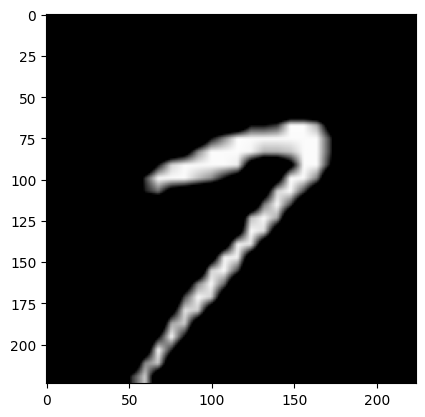

In [ ]:
img1 = train_dataset[71][0]
img2 = train_dataset[72][0]
show_tensor(img1)

In [ ]:
microstructure = img1[0]
mf = generate_torch_microstructure_function(microstructure, H, el)
ff_v2 = calculate_2point_torch_spatialstat(mf, H, el)

correlation computed: 0.07555 s


In [ ]:
def calc_sp_stat(img, H=H, el=el):
    # img is a torch tensor of size [1, H, W]
    microstructure = np.array(img[0])
    mf = generate_microstructure_function(microstructure, H, el)
    ff_v2 = cal_2p_spst(mf, H, el)
    #return torch.unsqueeze(torch.tensor(ff_v2), 0)
    return ff_v2

In [ ]:
def show_spst(arr1, title, arr2=None, title2=None):
    # arr1 and arr2 are numpy arrays of size [H, W]

    plt.figure(figsize=[11, 4])

    plt.subplot(121)
    ff_c = np.fft.fftshift(arr1)
    x_values = np.arange(-ff_c.shape[1] // 2, ff_c.shape[1] // 2)
    y_values = np.arange(-ff_c.shape[0] // 2, ff_c.shape[0] // 2)
    ax = plt.imshow(ff_c, origin='lower',
                    interpolation='none', cmap='gray', extent=[x_values[0], x_values[-1], y_values[0], y_values[-1]])

    plt.colorbar(ax)
    plt.title(f'Correlation ({title}): %s and %s' % (iA, iB))

    if title2 != None:
        plt.subplot(122)
        ff_c = np.fft.fftshift(arr2)
        x_values = np.arange(-ff_c.shape[1] // 2, ff_c.shape[1] // 2)
        y_values = np.arange(-ff_c.shape[0] // 2, ff_c.shape[0] // 2)
        ax = plt.imshow(ff_c, origin='lower',
                        interpolation='none', cmap='gray', extent=[x_values[0], x_values[-1], y_values[0], y_values[-1]])
        plt.colorbar(ax)
        plt.title(f'Correlation ({title2}): %s and %s' % (iA, iB))


    plt.show()

#### Test on rotations of images

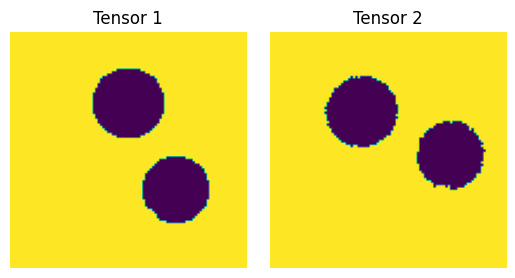

volume fraction phase 0: 0.13
correlation computed: 0.00521 s
volume fraction phase 0: 0.13
correlation computed: 0.00416 s


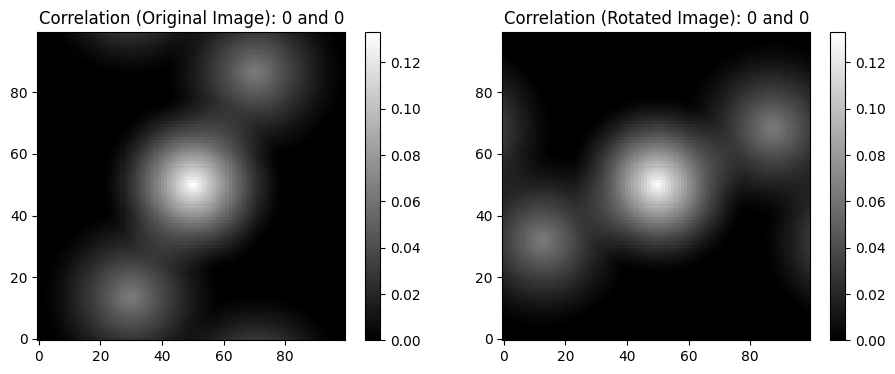

In [ ]:
image = img1
rotated_image = transforms.functional.rotate(image, 35)
crop = transforms.CenterCrop(100)
image, rotated_image = crop(image), crop(rotated_image)
show_tensors(image, rotated_image)
show_spst(calc_sp_stat(image, el=100), "Original Image", calc_sp_stat(rotated_image, el=100), "Rotated Image")

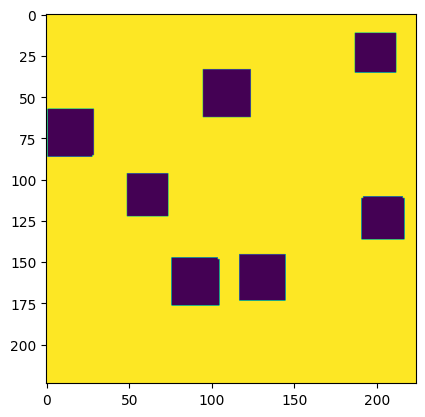

In [ ]:
img2 = train_dataset[10][0]
show_tensor(img2)

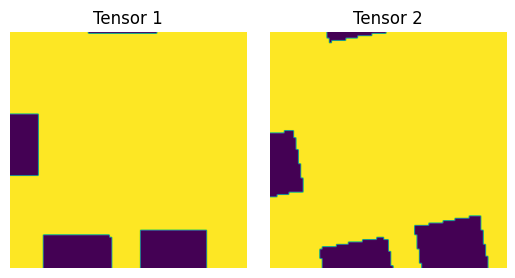

volume fraction phase 0: 0.12
correlation computed: 0.0058 s
volume fraction phase 0: 0.13
correlation computed: 0.0056 s


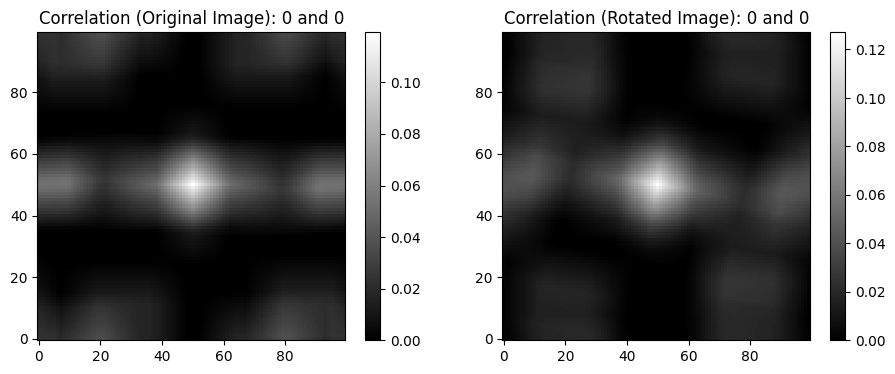

In [ ]:
image = train_dataset[10][0]
rotated_image = transforms.functional.rotate(image, 10)
crop = transforms.CenterCrop(100)
image, rotated_image = crop(image), crop(rotated_image)
show_tensors(image, rotated_image)
show_spst(calc_sp_stat(image, el=100), "Original Image", calc_sp_stat(rotated_image, el=100), "Rotated Image")

#### Test on translations of images

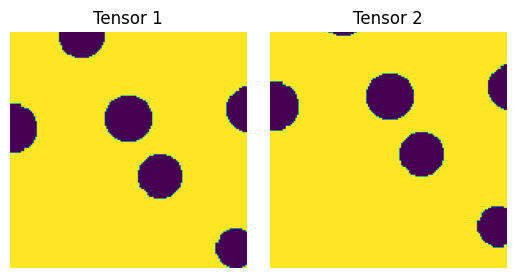

volume fraction phase 0: 0.13
correlation computed: 0.01034 s
volume fraction phase 0: 0.11
correlation computed: 0.0082 s


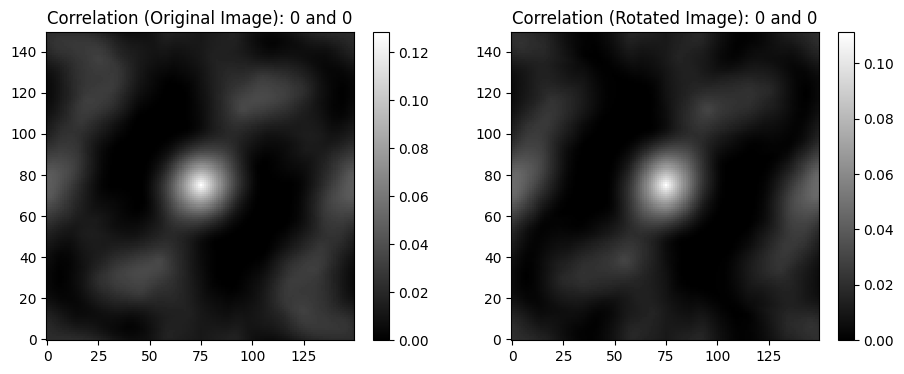

In [ ]:
image = img1
shift = transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2))
crop = transforms.CenterCrop(150)
image, translated_image = crop(image), crop(shift(image))
show_tensors(image, translated_image)
show_spst(calc_sp_stat(image, el=150), "Original Image", calc_sp_stat(translated_image, el=150), "Rotated Image")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


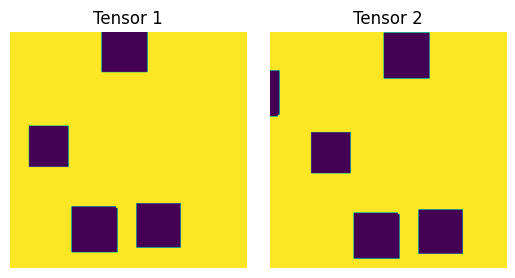

volume fraction phase 0: 0.13
correlation computed: 0.01118 s
volume fraction phase 0: 0.15
correlation computed: 0.00855 s


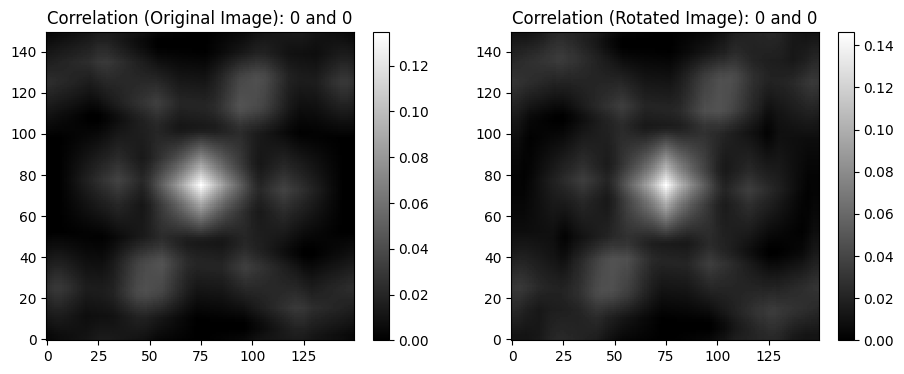

In [ ]:
image = train_dataset[10][0]
shift = transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2))
crop = transforms.CenterCrop(150)
image, translated_image = crop(image), crop(shift(image))
show_tensors(image, translated_image)
show_spst(calc_sp_stat(image, el=150), "Original Image", calc_sp_stat(translated_image, el=150), "Rotated Image")

#### compare different images of the same class

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


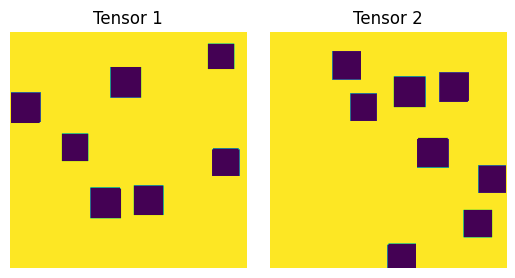

volume fraction phase 0: 0.1
correlation computed: 0.01919 s
volume fraction phase 0: 0.12
correlation computed: 0.01819 s


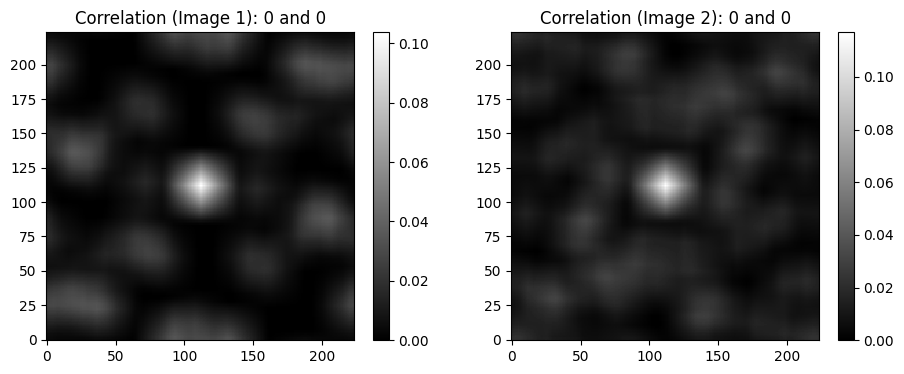

In [ ]:
image1 = train_dataset[10][0]
image2 = train_dataset[11][0]
show_tensors(image1, image2)
show_spst(calc_sp_stat(image1), "Image 1", calc_sp_stat(image2), "Image 2")

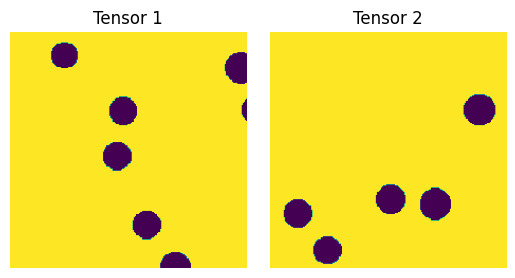

volume fraction phase 0: 0.06
correlation computed: 0.0296 s
volume fraction phase 0: 0.06
correlation computed: 0.02991 s


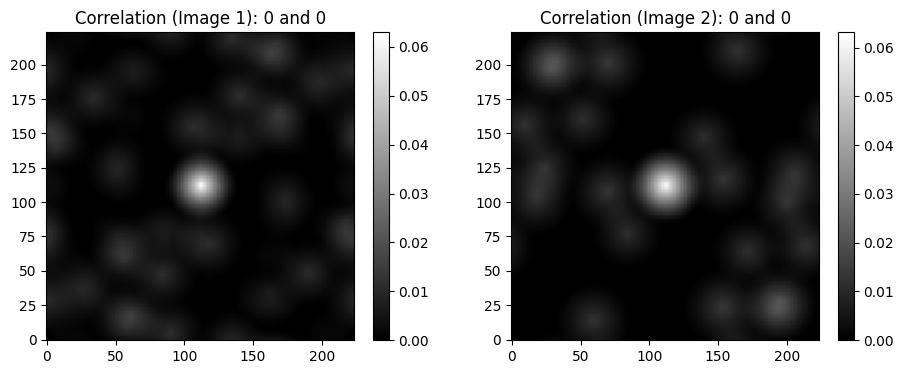

In [ ]:
image1 = train_dataset[8][0]
image2 = train_dataset[9][0]
show_tensors(image1, image2)
show_spst(calc_sp_stat(image1), "Image 1", calc_sp_stat(image2), "Image 2")

## 2-pt Spatial Statistics: FFT Approach for Batches of Images.

In [ ]:
el = res_size  # number of elements per side in the microstructure
H = 2  # number of phases in the microstructure
vf = .4  # volume fraction of phase 0
iA = 0  # phase A of correlation
iB = 0  # phase B of correlation

def generate_torch_microstructure_function(micr, H, el):
    """
    Inputs:
    micr: microstructure image (torch.Tensor) of shape W x H
    H: number of phases in the microstructure (int)
    el: length of micr along one dimension in pixels (int)

    returns:
    torch.Tensor microstructure function
    """
    mf = torch.zeros((H, el, el), device=micr.device, requires_grad=True)
    with torch.no_grad():
        for h in range(H):
            mf[h, ...] = micr.eq(h).clone().detach().to(micr.device)
    #frac = torch.sum(mf[0, ...]).float() / mf[0, ...].numel()
    #print("volume fraction phase 0: %s" % round(frac.item(), 2))
    return mf


def calculate_2point_torch_spatialstat(mf, H, el):
    """
    Inputs:
    mf: microstructure function torch.Tensor (el x el)
    H: number of phases in the microstructure (int)
    el: length of micr along one dimension in pixels (int)

    returns:
    ff_v2: 2d torch.Tensor FFT function
    """
    #st = time.time()

    M = torch.zeros((H, el, el), dtype=torch.complex128, device=mf.device)
    for h in range(H):
        M[h, ...] = torch.fft.fftn(mf[h, ...], dim=[0, 1])

    S = el**2

    M1 = M[iA, ...]
    mag1 = torch.abs(M1)

    eps=1e-6
    ang1 = torch.arctan2(M1.imag, M1.real+eps)
    exp1 = torch.exp(-1j*ang1)
    term1 = mag1*exp1

    M2 = M[iB, ...]
    mag2 = torch.abs(M2)
    ang2 = torch.arctan2(M2.imag, M2.real+eps)
    exp2 = torch.exp(1j*ang2)
    term2 = mag2*exp2

    FFtmp = term1*term2/S

    ff_v2 = torch.fft.ifftn(FFtmp, [el, el], [0, 1]).real

    #timeT = round(time.time()-st, 5)
    #print("correlation computed: %s s" % timeT)
    return ff_v2


def calculate_batch_2point_torch_spatialstat(mfs, H, el):
    """
    calculates spatial stats for a batch of microstructure functions
    mfs: microstructure function torch.Tensor (batch_size x el x el)
    H: number of phases in the microstructure (int)
    el: length of micr along one dimension in pixels (int)
    """
    return torch.concat([calculate_2point_torch_spatialstat(mf, H, el) for mf in mfs], dim=0)


def two_point_autocorr_pytorch(imgs, H=2):
    """
    PyTorch Implementation of 2-pt Spatial Statistics: FFT Approach.

    TODO: make this function take in batches

    img: torch.Tensor (shape batch_size x H x W) H=W
    H: number of phases in the microstructure (int)

    returns:
    torch.Tensor of size H x W
    """
    el = imgs.shape[-1]
    microstructure_functions = torch.concat([generate_torch_microstructure_function(img, H, el).unsqueeze(dim=0) for img in imgs], dim=0)
    ffts = calculate_batch_2point_torch_spatialstat(microstructure_functions, H, el)
    return ffts


class TwoPointFFTLoss(nn.Module):
    def __init__(self):
        super(TwoPointFFTLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, input, target):
        input_autocorr = two_point_autocorr_pytorch(input)
        target_autocorr = two_point_autocorr_pytorch(target)
        diff = self.mse_loss(input_autocorr, target_autocorr)
        return diff

## Autocorr

In [ ]:
# import torch
# import torch.nn as nn

def autocorr(x):
    """
    x is a 3 dimensional torch tensor.
    """
    if len(x.shape) < 4:
        x = torch.unsqueeze(x, dim=0)

    dim = x.shape[1]

    x = 2*x - 1
    x = torch.permute(x, (0, 3, 1, 2))
    x_complex = x.type(torch.complex64)

    M = torch.fft.fft2(x_complex)
    mag_M_complex = torch.abs(M).type(torch.complex64)

    # bug here: #RuntimeError: Function 'Atan2Backward0' returned nan values in its 0th output.
    # diagnosis: M.real becomes 0 which leads to NaN values into atan2
    # short-fix: add eps value to M.real
    eps=1e-6
    # TODO: is M.real negative anywhere?
    ang = torch.atan2(M.imag, M.real+eps)


    ang = ang.type(torch.complex64)

    device = ang.device
    # device = ang.get_device() # device used to be this
    exp1 = torch.exp(torch.complex(torch.tensor([0], dtype=torch.float32, device=device), torch.tensor([-1], dtype=torch.float32, device=device))*ang)
    exp2 = torch.exp(torch.complex(torch.tensor([0], dtype=torch.float32, device=device), torch.tensor([1], dtype=torch.float32, device=device))*ang)

    term1 = mag_M_complex*exp1
    term2 = mag_M_complex*exp2

    FFtmp = (term1*term2) / (32**2)

    autocorr = torch.fft.ifft2(FFtmp) # till here the values are the same upto 1e-7 tolerance
    autocorr = autocorr.real
    autocorr = torch.permute(autocorr, (0, 2, 3, 1))

    rv = torch.tensor(dim//2, dtype=torch.int32)
    # #autocorr = torch.roll(autocorr, rv, 1)
    # #autocorr = torch.roll(autocorr, rv, 2)
    autocorr = torch.roll(autocorr, dim//2, 2)
    # return autocorr

    return autocorr

In [ ]:
class FFTLoss(nn.Module):
    def __init__(self):
        super(FFTLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, input, target):
        input_autocorr = autocorr(input)
        target_autocorr = autocorr(target)
        diff = self.mse_loss(input_autocorr, target_autocorr)
        return diff

## 2-Pt Autocorr

### Test spatial stats on images

In [ ]:
def show_tensors(t1, t2):
    # Create a figure and subplot
    fig, axs = plt.subplots(1, 2)

    # Plot the first tensor
    axs[0].imshow(t1.permute(1, 2, 0))
    axs[0].set_title('Tensor 1')

    # Plot the second tensor
    axs[1].imshow(t2.permute(1, 2, 0))
    axs[1].set_title('Tensor 2')

    # Remove the axis labels
    for ax in axs:
        ax.axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1)

    # Show the plot
    plt.show()

#### Test on MNIST

In [ ]:
(train_dataset.targets==0).nonzero(as_tuple=True)[0]

tensor([    1,    21,    34,  ..., 59952, 59972, 59987])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


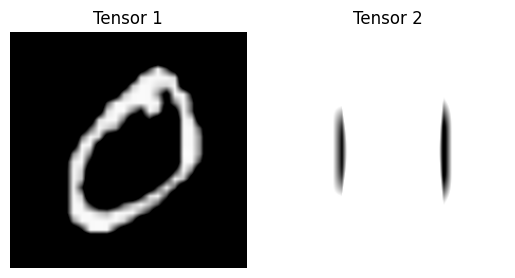

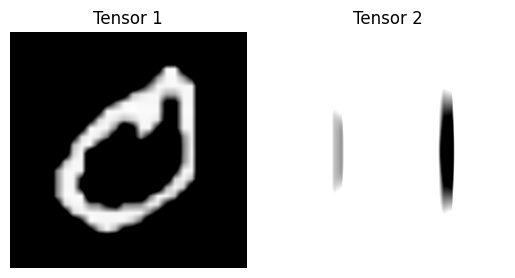

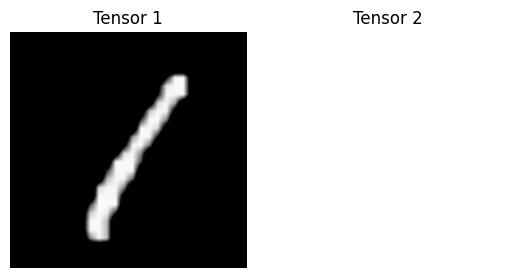

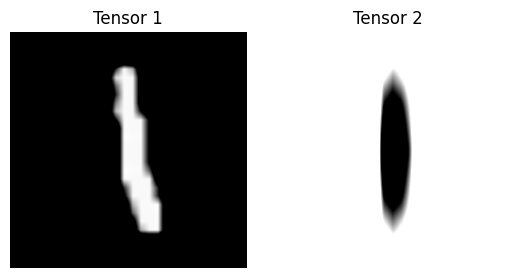

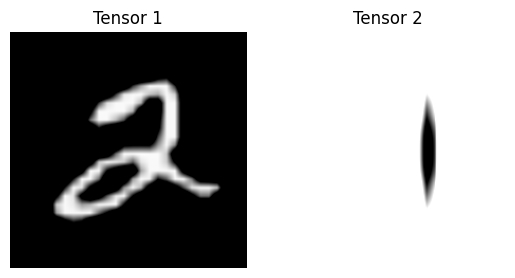

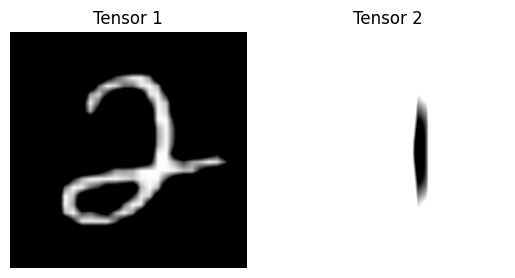

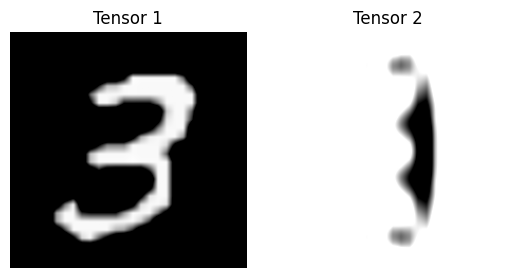

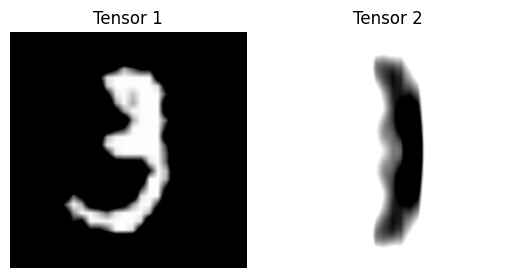

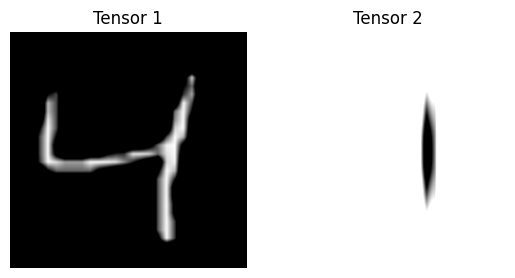

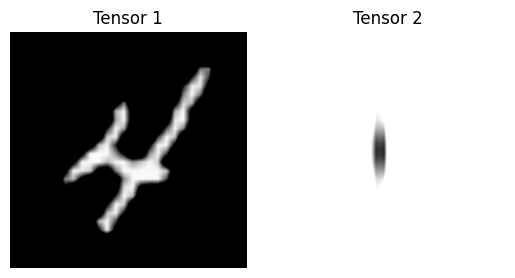

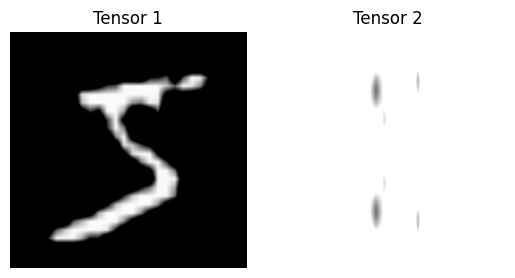

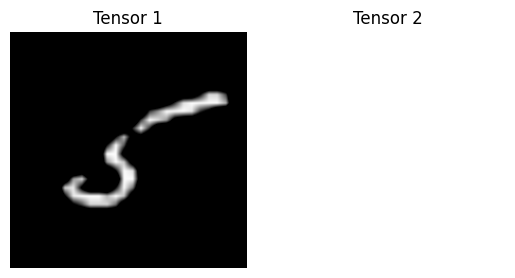

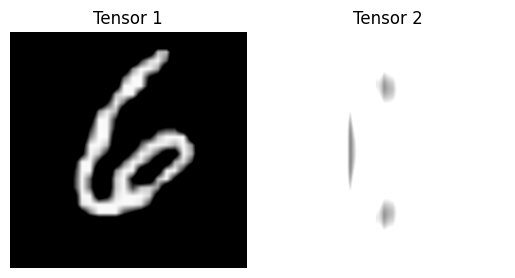

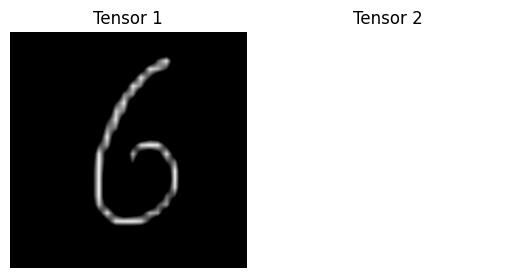

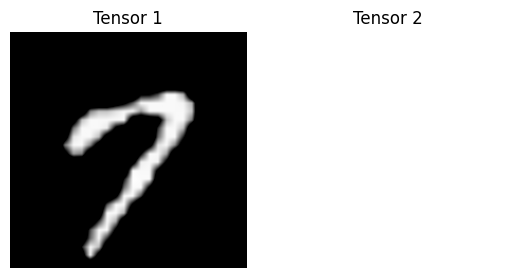

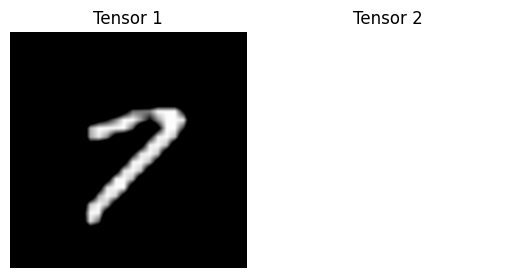

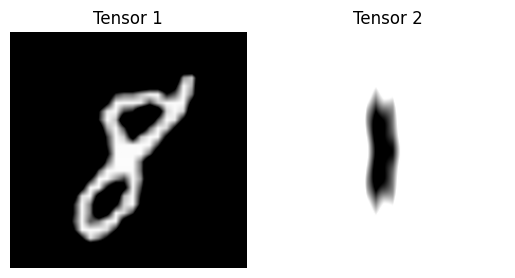

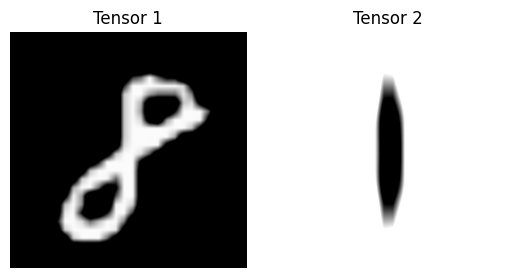

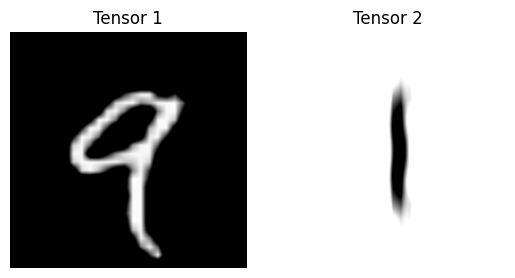

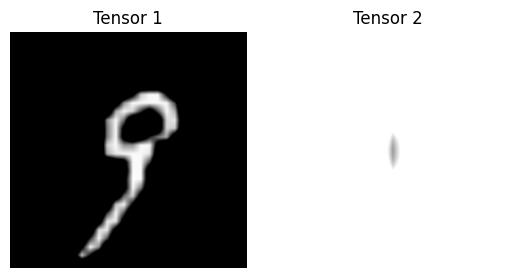

In [ ]:
for i in range(10):
    idxs = (train_dataset.targets==i).nonzero(as_tuple=True)[0]
    a, b = idxs[:2]

    image1 = train_dataset[a][0]
    spst_image1 = autocorr(image1) # spatial stats for image1
    show_tensors(image1, spst_image1[0])

    image2 = train_dataset[b][0]
    spst_image2 = autocorr(image2) # spatial stats for image2
    show_tensors(image2, spst_image2[0])

#### Test on texture data

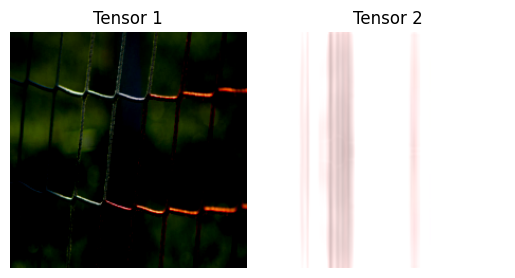

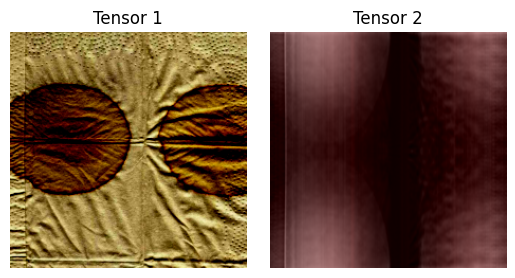

In [ ]:
image1 = train_dataset[1000][0]
spst_image1 = autocorr(image1) # spatial stats for image1
show_tensors(image1, spst_image1[0])

image2 = train_dataset[1500][0]
spst_image2 = autocorr(image2) # spatial stats for image2
show_tensors(image2, spst_image2[0])

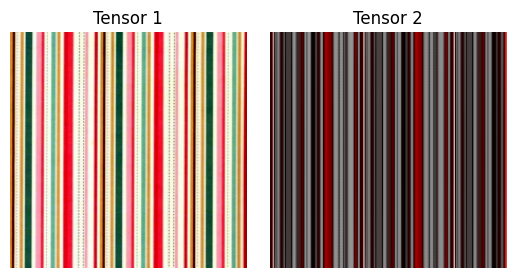

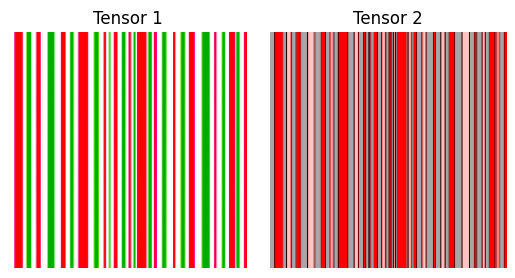

In [ ]:
image1 = train_dataset[1][0]
spst_image1 = autocorr(image1) # spatial stats for image1
show_tensors(image1, spst_image1[0])

image2 = train_dataset[0][0]
spst_image2 = autocorr(image2) # spatial stats for image2
show_tensors(image2, spst_image2[0])

##### Test on rotations of the same image
Rotate by 45 deg and test the spatial stats. The spatial stats of the rotated
image and the original image should be the same.

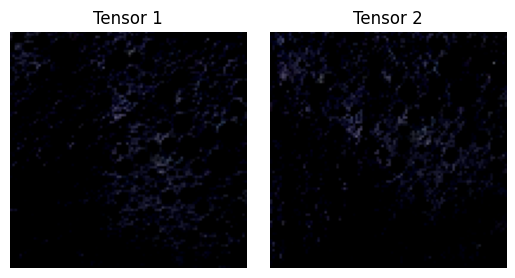

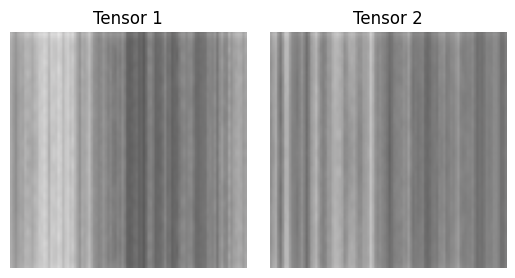

In [ ]:
image = train_dataset[124][0] #56 #100
rotated_image = transforms.functional.rotate(image, 45)
crop = transforms.CenterCrop(100)
image, rotated_image = crop(image), crop(rotated_image)
show_tensors(image, rotated_image)
show_tensors(autocorr(image)[0], autocorr(rotated_image)[0])

##### Test on translations of the same image

Image 50


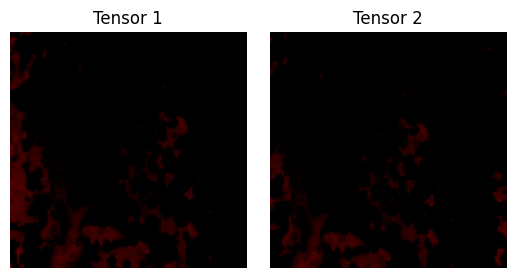

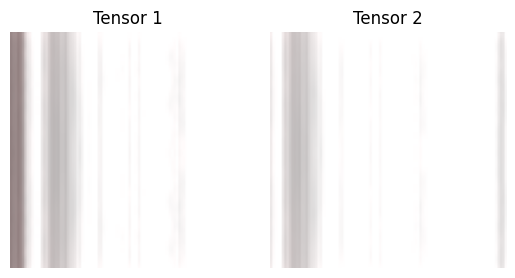

Image 51


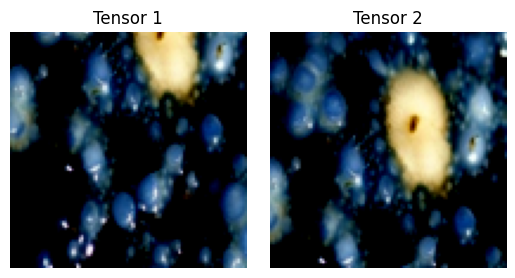

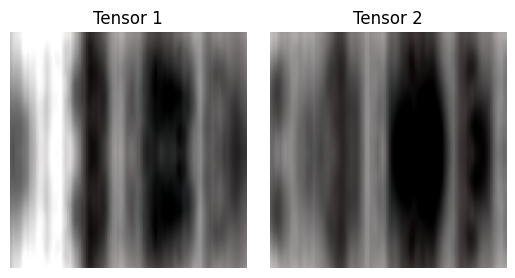

Image 52


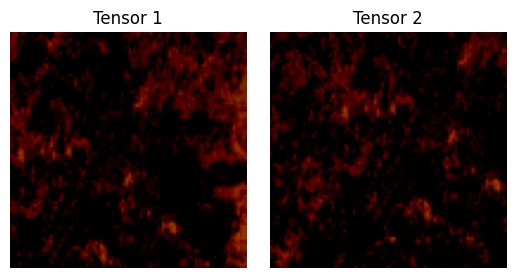

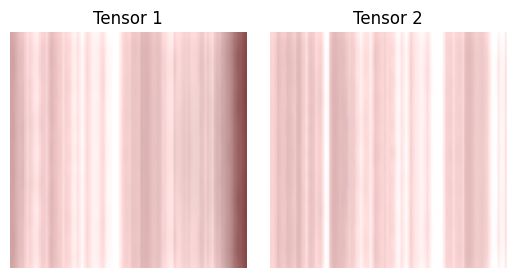

Image 53


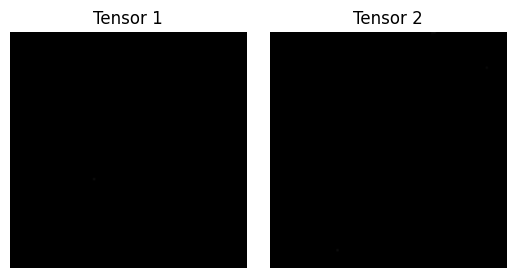

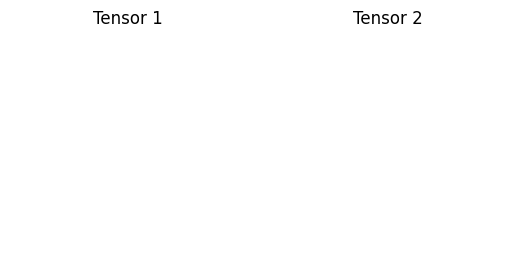

Image 54


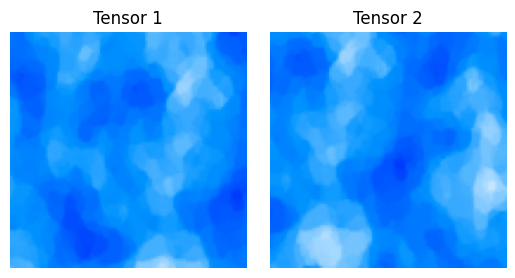

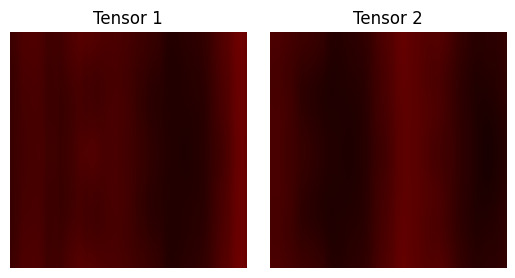

Image 55


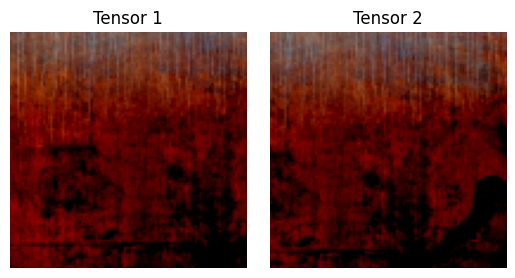

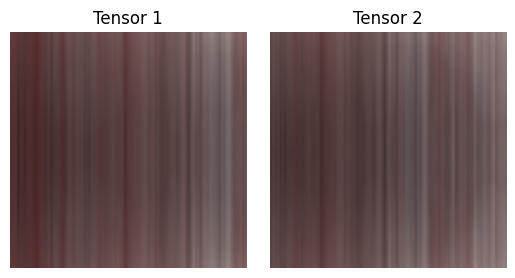

Image 56


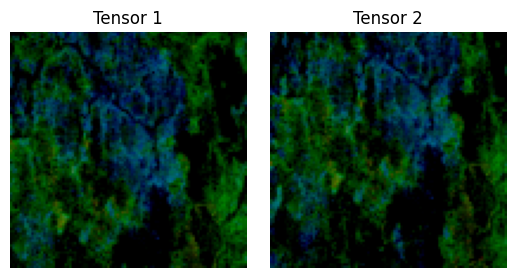

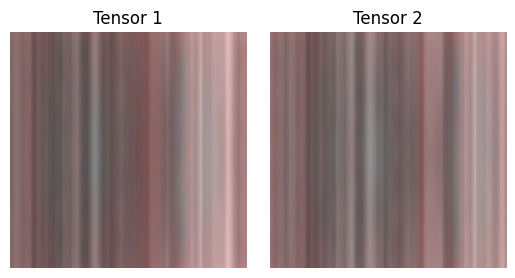

Image 57


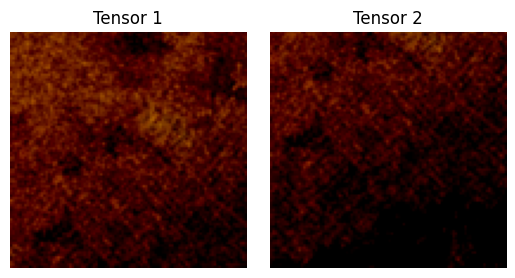

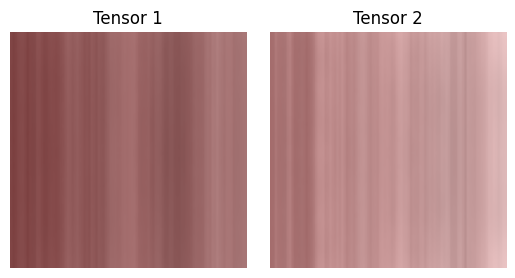

Image 58


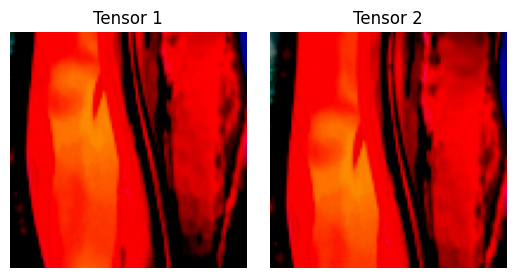

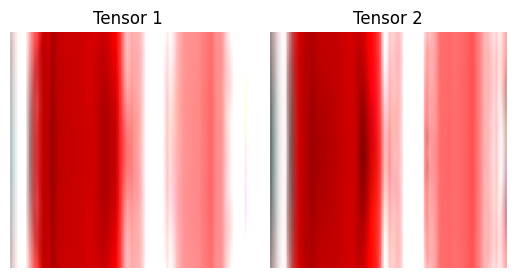

Image 59


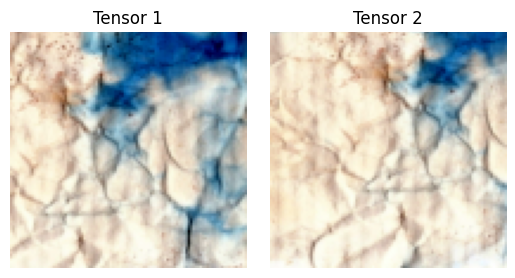

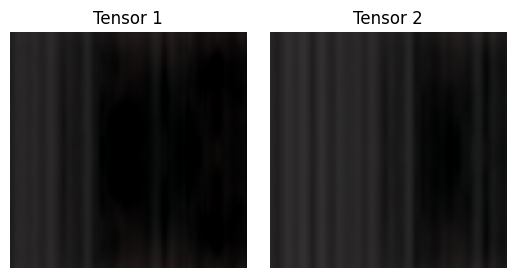

In [ ]:
for i in range(50, 60):
    print(f"Image {i}")
    image = train_dataset[i][0] #56 #100
    shift = transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2))
    crop = transforms.CenterCrop(100)
    image, shifted_image = crop(image), crop(shift(image))
    show_tensors(image, shifted_image)
    show_tensors(autocorr(image)[0], autocorr(shifted_image)[0])

# Model Training

In [ ]:
def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)


# LOSS
fft_loss = TwoPointFFTLoss()
def loss_function(recon_x, x, mu, logvar, beta=1):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    fftloss = fft_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return 0.5*(fftloss + MSE) + beta*KLD


def train(log_interval, model, device, train_loader, optimizer, epoch, save_model_path):
    # set model as training mode
    model.train()

    losses = 0
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)

        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)  # VAE
        loss = loss_function(X_reconst, X, mu, logvar)
        losses += loss.item()

        loss.backward()
        optimizer.step()

        all_y.extend(y.data.cpu().numpy())
        all_z.extend(z.data.cpu().numpy())
        all_mu.extend(mu.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    losses /= len(train_loader.dataset)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # save Pytorch models of best record
    if (epoch+1)%100==0:
        torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
        torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
        print("Epoch {} model saved!".format(epoch + 1))

    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, losses


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)

            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss

            all_y.extend(y.data.cpu().numpy())
            all_z.extend(z.data.cpu().numpy())
            all_mu.extend(mu.data.cpu().numpy())
            all_logvar.extend(logvar.data.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, test_loss



In [ ]:
import time
# training parameters
epochs = 100        # training epochs
learning_rate = 1e-3
log_interval = 2   # interval for displaying training info


resume_training = True
if resume_training:
    last_epoch = 50
else:
    last_epoch = 0
# # save model
# save_model_path = 'drive/MyDrive/argonne/results_circles'
# # save_model_path = 'drive/MyDrive/argonne/results_MNIST'
# # save_model_path = "drive/MyDrive/argonne/results_DTD"

# # Detect devices
# use_cuda = torch.cuda.is_available()                   # check if GPU exists
# device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# # EncoderCNN architecture
# CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
# CNN_embed_dim = 256     # latent dim extracted by 2D CNN
# dropout_p = 0.2       # dropout probability
# # Create model
# resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
# resnet_vae.resnet.requires_grad_(False)
# model_params = list(resnet_vae.parameters())
# optimizer = torch.optim.Adam(model_params, lr=learning_rate)
# if resume_training:
#     resnet_vae.load_state_dict(torch.load(os.path.join(save_model_path,f'model_epoch{last_epoch}.pth')))
#     optimizer.load_state_dict(torch.load(os.path.join(save_model_path,f'optimizer_epoch{last_epoch}.pth')))
#     print("Resuming pretrained model...")
# if use_cuda:
#     print("Using", torch.cuda.device_count(), "GPU!")
# else:
#     print("Training on CPU!")

# # record training process
# #epoch_train_losses = []
# #epoch_test_losses = []
# check_mkdir(save_model_path)
# #check_mkdir(drive_model_path)

#start training
for epoch in range(epochs-last_epoch):
    start = time.time()
    epoch = epoch + last_epoch
    # train, test model
    X_train, y_train, z_train, mu_train, logvar_train, train_loss = train(log_interval, resnet_vae, device, train_loader, optimizer, epoch, save_model_path)
    X_test, y_test, z_test, mu_test, logvar_test, test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_loss)
    epoch_test_losses.append(test_loss)


    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)

    if (epoch+1)%100==0:
        np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
        np.save(os.path.join(save_model_path, 'X_MNIST_train_epoch{}.npy'.format(epoch + 1)), X_train) #save last batch
        np.save(os.path.join(save_model_path, 'y_MNIST_train_epoch{}.npy'.format(epoch + 1)), y_train)
        np.save(os.path.join(save_model_path, 'z_MNIST_train_epoch{}.npy'.format(epoch + 1)), z_train)
    print(f"epoch time elapsed {time.time() - start} seconds")

Train Epoch: 51 [64/14000 (0%)]	Loss: 45802.422184
Train Epoch: 51 [128/14000 (1%)]	Loss: 50779.521322
Train Epoch: 51 [192/14000 (1%)]	Loss: 47507.137280
Train Epoch: 51 [256/14000 (2%)]	Loss: 47627.220762
Train Epoch: 51 [320/14000 (2%)]	Loss: 50102.567700
Train Epoch: 51 [384/14000 (3%)]	Loss: 45853.665597
Train Epoch: 51 [448/14000 (3%)]	Loss: 46039.413629
Train Epoch: 51 [512/14000 (4%)]	Loss: 43709.808170
Train Epoch: 51 [576/14000 (4%)]	Loss: 47287.189768
Train Epoch: 51 [640/14000 (5%)]	Loss: 44246.288879
Train Epoch: 51 [704/14000 (5%)]	Loss: 44048.789368
Train Epoch: 51 [768/14000 (5%)]	Loss: 46810.452963
Train Epoch: 51 [832/14000 (6%)]	Loss: 49008.780324
Train Epoch: 51 [896/14000 (6%)]	Loss: 50404.707839
Train Epoch: 51 [960/14000 (7%)]	Loss: 48450.590405
Train Epoch: 51 [1024/14000 (7%)]	Loss: 43900.632136
Train Epoch: 51 [1088/14000 (8%)]	Loss: 47357.471747
Train Epoch: 51 [1152/14000 (8%)]	Loss: 43217.432667
Train Epoch: 51 [1216/14000 (9%)]	Loss: 50255.372151
Train Epo

FileNotFoundError: ignored

In [ ]:
#torch.autograd.set_detect_anomaly(True)

time/epoch = 1hr 10 mins

# Results

In [ ]:
def decoder(model, device, z):
    model.eval()
    z = Variable(torch.FloatTensor(z)).to(device)
    new_images_torch = model.decode(z).data.cpu()
    #new_images = model.decode(z).squeeze_().data.cpu().numpy().transpose((1, 2, 0))
    #new_images_numpy = new_images_torch.squeeze_().numpy().transpose((1, 2, 0))
    #return new_images_torch, new_images_numpy
    return new_images_torch

## MNIST

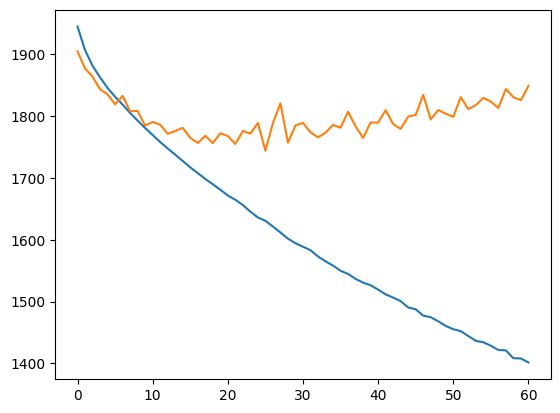

In [ ]:
plt.figure()
plt.plot(range(len(epoch_train_losses)), epoch_train_losses, label="train loss")
plt.plot(range(len(epoch_test_losses)), epoch_test_losses, label="test loss")
#plt.legend()

In [ ]:
epoch = 64
torch.save(resnet_vae.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch)))  # save motion_encoder
torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch)))      # save optimizer
print("Epoch {} model saved!".format(epoch))

np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
np.save(os.path.join(save_model_path, 'X_MNIST_train_epoch{}.npy'.format(epoch)), X_train) #save last batch
np.save(os.path.join(save_model_path, 'y_MNIST_train_epoch{}.npy'.format(epoch)), y_train)
np.save(os.path.join(save_model_path, 'z_MNIST_train_epoch{}.npy'.format(epoch)), z_train)

Epoch 64 model saved!


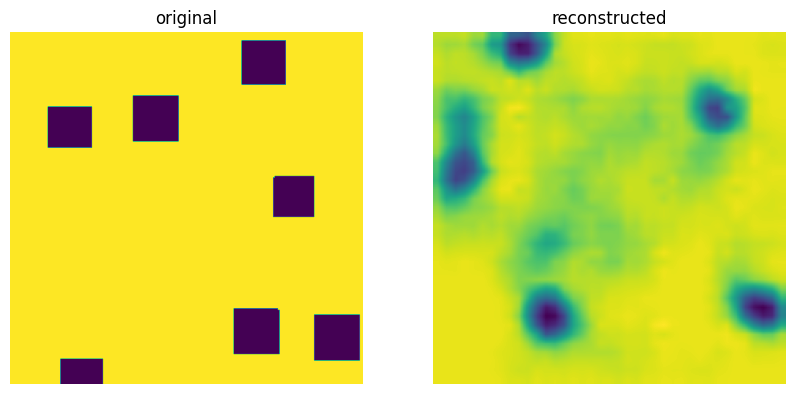

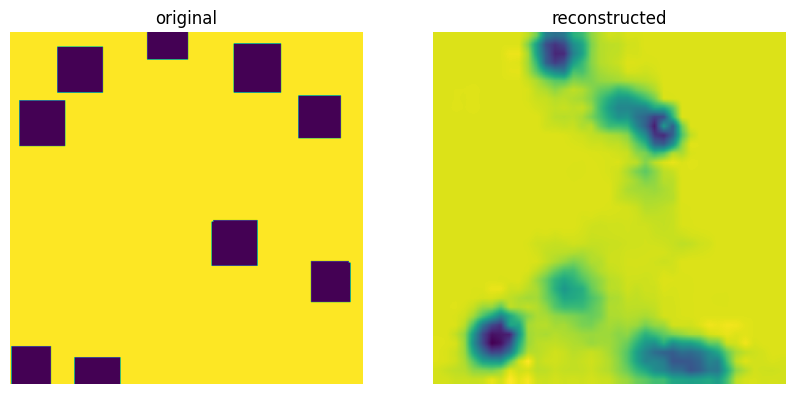

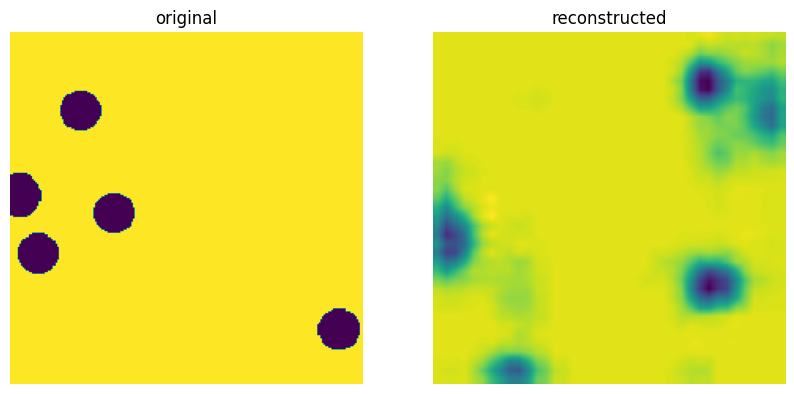

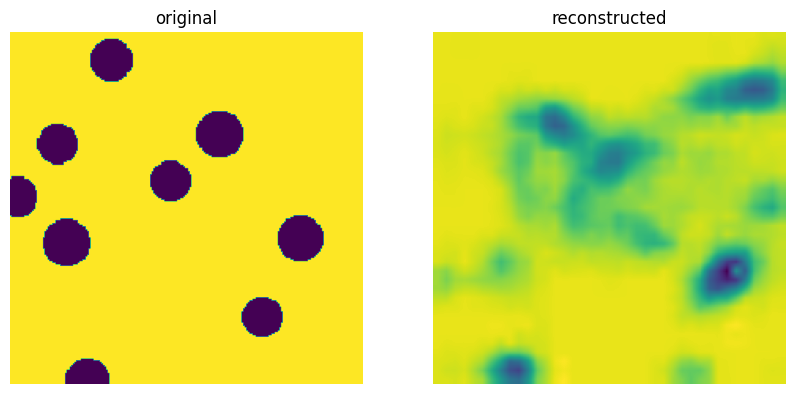

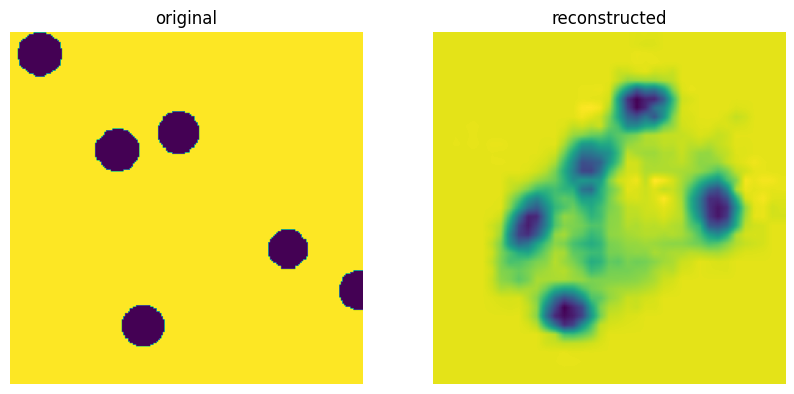

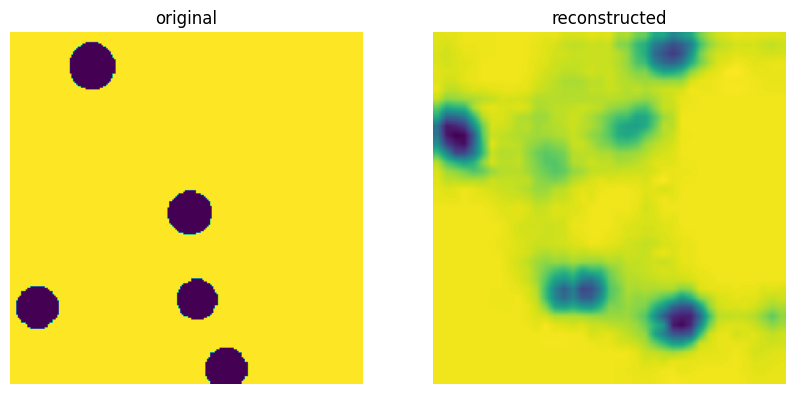

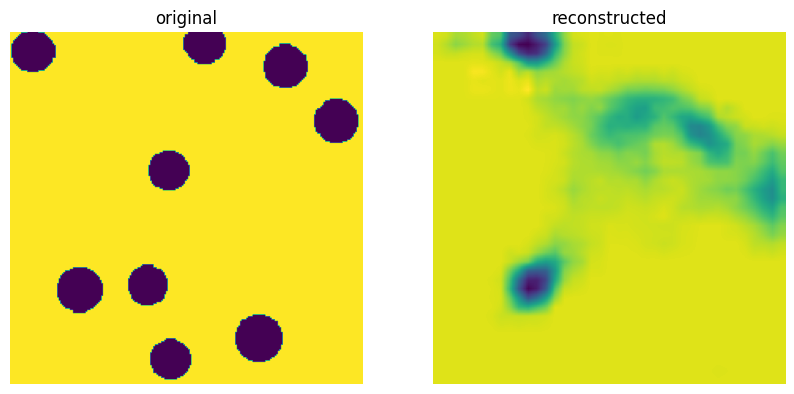

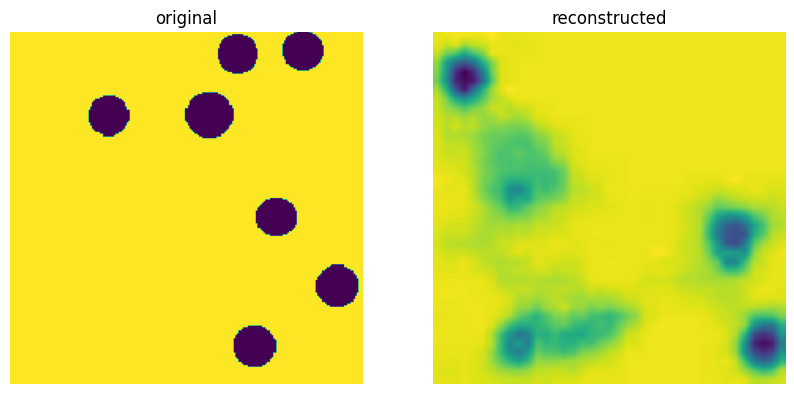

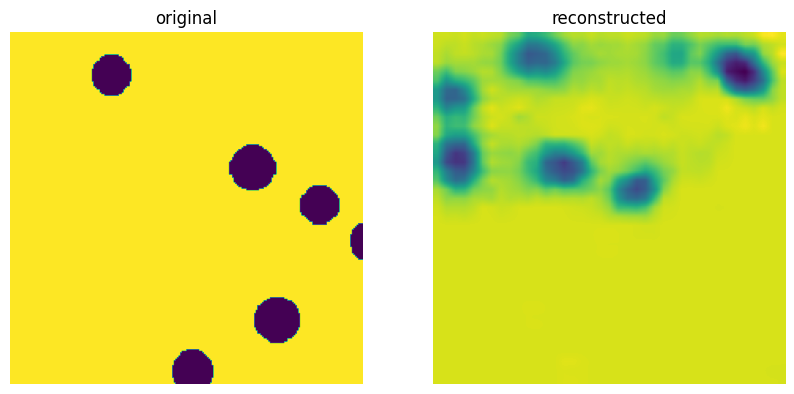

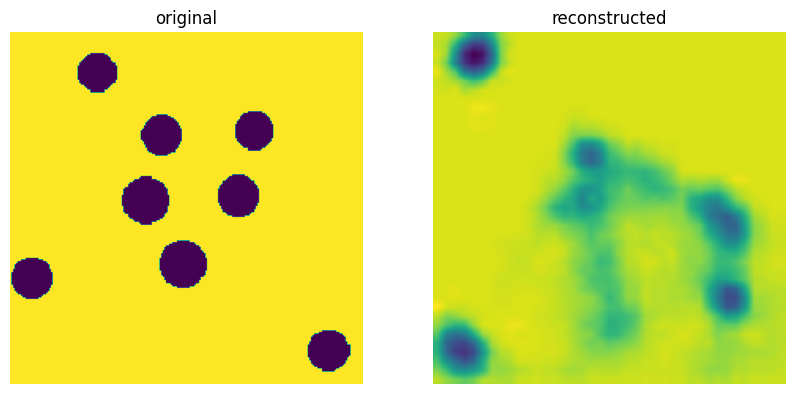

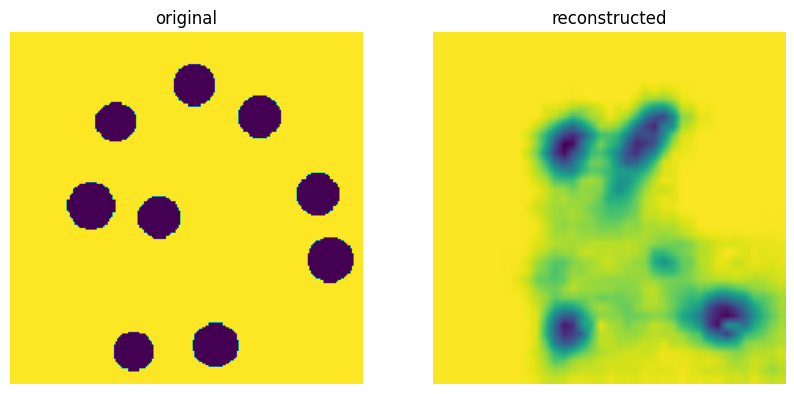

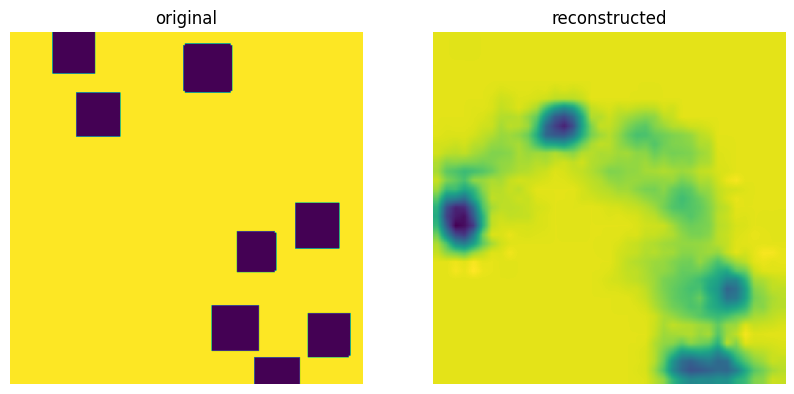

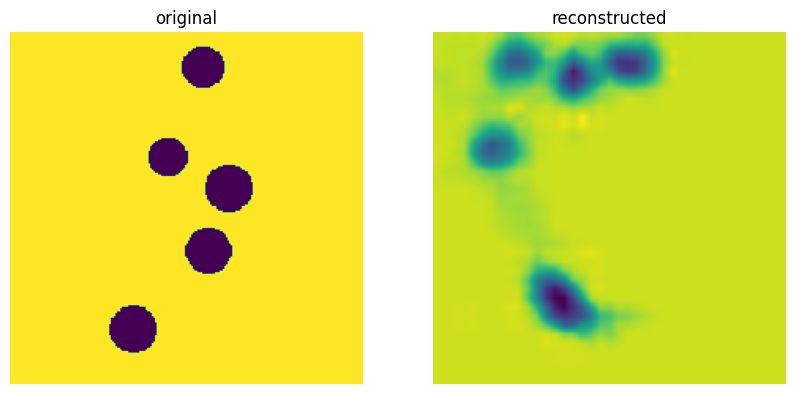

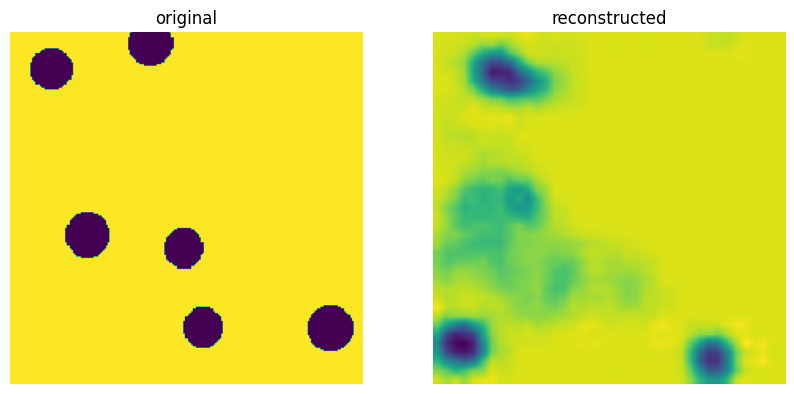

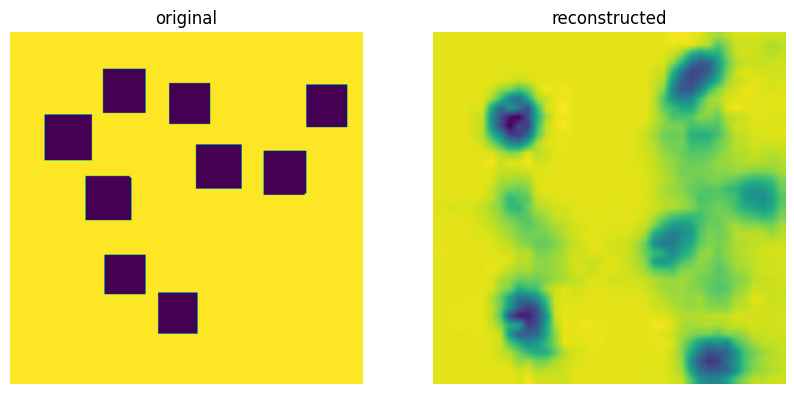

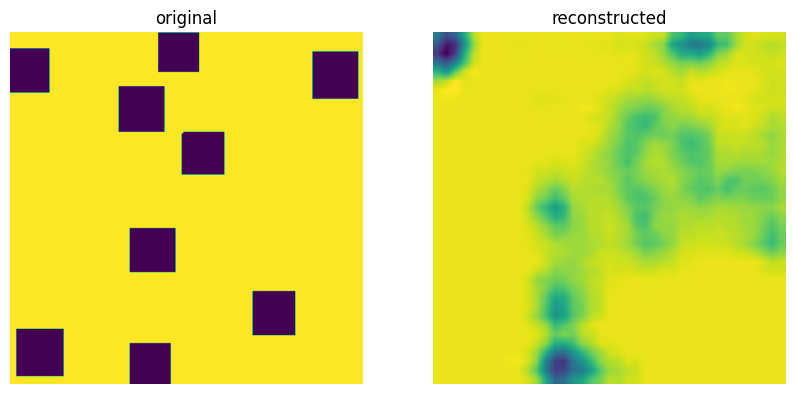

In [ ]:
exp = "MNIST"
epoch = 64
z_train = np.load(os.path.join(save_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
X_train = np.load(os.path.join(save_model_path, 'X_{}_train_epoch{}.npy').format(exp, epoch))

for ind in range(len(X_train)):
    zz = torch.from_numpy(z_train[ind]).view(1, -1)
    #x = torch.from_numpy(X_train[ind])
    X = np.transpose(X_train[ind], (1, 2, 0))

    #new_imgs_torch, new_images_np = decoder(resnet_vae, device, zz)
    new_imgs_torch = decoder(resnet_vae, device, zz)

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(X)
    plt.title('original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(new_imgs_torch[0][0])
    plt.title('reconstructed')
    plt.axis('off')
    plt.savefig("./reconstruction_{}.png".format(exp), bbox_inches='tight', dpi=600)
    plt.show()
    #show_tensors(autocorr(x)[0], autocorr(new_imgs_torch)[0])

# TODO: compare the spatial statistics of original and the reconstructed
# TODO: try rotations of the MNIST rotations by 45 deg (spatial statistics is rotation invariant)

# check to see if any of the reconstructions will be rotated.
# let it converge. make the initialized weights smaller.

## DTD

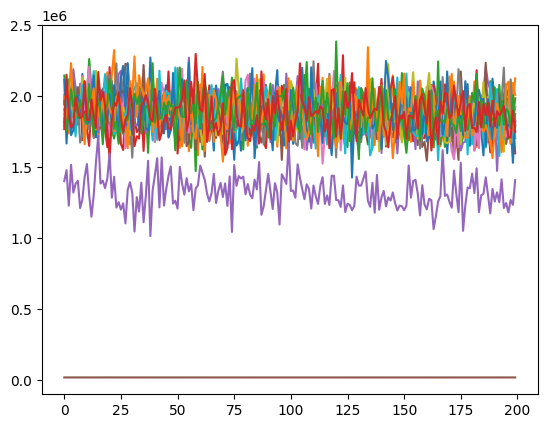

In [ ]:
plt.figure()
plt.plot(range(len(epoch_train_losses)), epoch_train_losses, label="train loss")
plt.plot(range(len(epoch_test_losses)), epoch_test_losses, label="test loss")
#plt.legend()

In [ ]:
exp = "MNIST"
epoch = 400
z_train = np.load(os.path.join(save_model_path, 'z_{}_train_epoch{}.npy').format(exp, epoch))
X_train = np.load(os.path.join(save_model_path, 'X_{}_train_epoch{}.npy').format(exp, epoch))

for ind in range(len(X_train)):
    zz = torch.from_numpy(z_train[ind]).view(1, -1)
    x = torch.from_numpy(X_train[ind])
    X = np.transpose(X_train[ind], (1, 2, 0))

    new_imgs_torch, new_images_np = decoder(resnet_vae, device, zz)

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(X)
    plt.title('original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(new_images_np)
    plt.title('reconstructed')
    plt.axis('off')
    plt.savefig("./reconstruction_{}.png".format(exp), bbox_inches='tight', dpi=600)
    plt.show()
    show_tensors(autocorr(x)[0], autocorr(new_imgs_torch)[0])

# TODO: compare the spatial statistics of original and the reconstructed
# TODO: try rotations of the MNIST rotations by 45 deg (spatial statistics is rotation invariant)
#       - The spatial stat of the rotation wasn't the same :(
#       - TODO: Try another rotation function from a diff package

# check to see if any of the reconstructions will be rotated.
# let it converge. make the initialized weights smaller.